In [3]:
server_address = 'https://cosmetic-defect-mask-cpu-gcr-43d6z4cgbq-uc.a.run.app'
server_port = 443
example_images = 'gs://cosmetic-defect-detection/cosmetic-defect-detection-data/public_original/*.png'
max_images = 500

threshold = 0.
softmax = False

In [4]:
!pip install absl-py

In [5]:
!pip install tensorflow

In [6]:
!pip install pandas
!pip install matplotlib
!pip install PIL

ERROR: Could not find a version that satisfies the requirement PIL (from versions: none)
ERROR: No matching distribution found for PIL


In [7]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import base64
import cv2
import json
import time

from absl import app
from absl import flags
import numpy as np
import requests

from google.auth.transport import requests as reqs
from google.oauth2 import id_token

import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image

from tqdm import tqdm
import re
from joblib import Parallel, delayed

2021-11-30 15:10:59.545385: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-11-30 15:10:59.545432: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [8]:
#Helpers
def gen_endpoint_url(hostname, port):
    return f'{hostname}:{str(port)}/v1beta1/visualInspection:predict'

def create_request_body_bytes(input_image_file):
    with tf.io.gfile.GFile(input_image_file, 'rb') as image_file:
        encoded_string = base64.b64encode(image_file.read()).decode('utf-8')
    request_body = {'image_bytes': str(encoded_string), 'image_id': input_image_file}
    return json.dumps(request_body)

def gen_id_creds(url):
    return id_token.fetch_id_token(reqs.Request(), url)

def predict(hostname, input_image, port=8602, with_token=True, token=None):
    headers = {}
    if with_token:
        headers.update({'Authorization': f'Bearer {token or gen_id_creds(hostname)}'})
    response = requests.post(gen_endpoint_url(hostname, port), 
                             data=create_request_body_bytes(input_image),
                             headers=headers)
    if response.status_code != requests.codes.ok:
        print(f'code: {response.status_code}, header: {response.headers}, body: {response.text}')
    return response.json()

def extract_anomaly(response):
    anomaly_score = 0
    for group in response['predictionResult']['annotationsGroups']:
        for annotation in group['annotations']:
            if 'classificationLabel' in annotation and 'confidenceScore' in annotation['classificationLabel']:
                anomaly_score = annotation['classificationLabel']['confidenceScore']
    
    return anomaly_score

def extract_masks(response):
    scores = []
    category = []

    for group in response['predictionResult']['annotationsGroups']:
        for annotation in group['annotations']:
            if 'mask' in annotation:
                scores_bytes = annotation['mask']['confidenceMask']['imageBytes']
                scores = cv2.imdecode(np.frombuffer(base64.b64decode(scores_bytes), np.uint8), cv2.IMREAD_GRAYSCALE) / 255.

                category_bytes = annotation['mask']['categoryMask']['imageBytes']
                category = cv2.imdecode(np.frombuffer(base64.b64decode(category_bytes), np.uint8), cv2.IMREAD_COLOR)
    
    return scores, category

def confidence_filter_mask(scores, threshold=.5):
    return scores > threshold

def extract_color_map(response):
    return {color['annotationSpecId']: color['color'] 
            for group in response['predictionResult']['annotationsGroups']
            for annotation in group['annotations']
            if 'mask' in annotation
            for color in annotation['mask']['annotationSpecColors']
            if all(col in color['color'] for col in ['red', 'green', 'blue'])}

def color_to_bgr_tuple(color):
    return (np.array((color['blue'], color['green'], color['red'])) * 255).astype(int)

def calculate_binary_masks(category_mask, color_map, confidence_filter=1):
    return {spec: (category_mask == color_to_bgr_tuple(col)).max(axis=-1) * confidence_filter for spec, col in color_map.items()}

def binary_masks_to_sum_pixels(binary_masks):
    return {spec: binary_mask.sum() for spec, binary_mask in binary_masks.items()}

def calculate_confidence_means_total(confidence_mask, binary_masks, with_softmax=False):
    scores_means = {spec: np.sum(binm * confidence_mask) / confidence_mask.size for spec, binm in binary_masks.items()}
    return apply_softmax(scores_means) if with_softmax else scores_means

def calculate_confidence_means(confidence_mask, binary_masks, with_softmax=False):
    scores_means = {spec: (binm * confidence_mask).sum() / binm.sum() for spec, binm in binary_masks.items()}
    return apply_softmax(scores_means) if with_softmax else scores_means

def calculate_confidence_maxs(confidence_mask, binary_masks, with_softmax=False):
    scores_max = {spec: (binm * confidence_mask).max() for spec, binm in binary_masks.items()}
    return apply_softmax(scores_max) if with_softmax else scores_max

def calculate_confidence_mins(confidence_mask, binary_masks):
    return {spec: (binm * confidence_mask).min() for spec, binm in binary_masks.items()}

def apply_softmax(confidence_values):
    scores_ar = np.array(list(confidence_values.values()))
    non_zero_mask = ~np.equal(scores_ar, 0)
    scores_ar[non_zero_mask] = tf.nn.softmax(scores_ar[non_zero_mask]).numpy()
    return {key: val for key, val in zip(confidence_values.keys(), scores_ar)}

def load_image(image):
    input_ar = np.asarray(Image.open(tf.io.gfile.GFile(image, 'rb')))
    out_ar = input_ar.astype(np.float32)
    if input_ar.dtype == np.uint8:
        out_ar /= 255
    return out_ar

def sharpness_by_laplacian(image):
    return cv2.Laplacian(image, ddepth=cv2.CV_32F).var() / 0.0001

def plot_prediction(image, category_mask, scores_mask, truth, predicted, scores):
    title = f"image: {image},\n truth: {truth}, predicted: {predicted},\n scores: {scores}"
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=[20,7])
    ax[0].imshow(plt.imread(tf.io.gfile.GFile(image, 'rb')))
    ax[0].axis('off')
    ax[1].imshow(category_mask)
    ax[1].axis('off')
    ax[2].imshow(scores_mask)
    ax[2].axis('off')
    fig.suptitle(title)
    plt.show()

In [9]:
predict(server_address, tf.io.gfile.glob(example_images)[0], server_port)

{'predictionResult': {'annotationsGroups': [{'annotationSet': {'name': 'projects/996456550291/locations/us-central1/datasets/1380485227184390144/annotationSets/510868286636818432',
     'displayName': 'Predicted Masks Regions',
     'mask': {},
     'createTime': '2021-11-29T10:12:24.831971Z',
     'updateTime': '2021-11-29T10:12:24.831971Z'},
    'annotations': [{'name': 'localAnnotations/1',
      'annotationSetId': '510868286636818432',
      'mask': {'confidenceMask': {'imageBytes': 'iVBORw0KGgoAAAANSUhEUgAAAaAAAAGUCAAAAABWtqk+AAAAuUlEQVR4Xu3BAQEAAACCIP+vbkhAAQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAPwakjIAAYuD8gQAAAAASUVORK5CYII='},
       'categoryMask': {'imageBytes': 'iVBORw0KGgoAAAANSUhEUgAAAaAAAAGUCAIAAAD8v2G1AAAB/0lEQVR4Xu3BAQ0AAADCoPdPbQ8HFAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA

In [11]:
results = Parallel(n_jobs=8)(delayed(predict)(server_address, example_image, server_port) for example_image in tqdm(tf.io.gfile.glob(example_images)[:max_images]))

 22%|██▏       | 8/36 [00:00<00:00, 52.48it/s]2021-11-30 15:12:46.431164: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-11-30 15:12:46.438179: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2021-11-30 15:12:46.470008: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-11-30 15:12:46.470246: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2021-11-30 15:12:46.472689: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot

In [14]:
mask_results = []
class_results = []
for result in tqdm(results):
    try:
        score_anomaly = extract_anomaly(result)
        scores_mask, category_mask = extract_masks(result)
        color_map = extract_color_map(result)
        mask_results.append({'image': result['imageId'], 'scores': scores_mask, 'categories': category_mask})
        
        binary_masks = calculate_binary_masks(category_mask, color_map, confidence_filter_mask(scores_mask, threshold=threshold))
        if sharpness_by_laplacian(load_image(result['imageId'])) < 1:
            scores = {'blurred': 1.}
        else:
            scores = {'blurred': 0., **calculate_confidence_maxs(scores_mask, binary_masks, with_softmax=softmax)}
        labels_max = str(max(scores, key=scores.get)) if len(scores.values()) and max(scores.values()) > threshold else 'pass'
        all_scores = {'pass': 0. if labels_max != 'pass' else 1., **scores}
        
        class_results.append({'image': result['imageId'], 'max': labels_max, 'anomaly': score_anomaly, **all_scores})
    except Exception as e:
        print(f'{type(e)} exception {e} ({e.args}), result: {result}')
    
df = pd.DataFrame(class_results).fillna(0)
df.to_csv('results.csv', index=False)
df

100%|██████████| 36/36 [00:04<00:00,  7.43it/s]


,image,max,anomaly,pass,blurred,2877913411587407872,5183756420801101824
0,gs://cosmetic-defect-detection/cosmetic-defect...,pass,0.156047,1.0,0.0,0.000000,0.000000
1,gs://cosmetic-defect-detection/cosmetic-defect...,2877913411587407872,0.317354,0.0,0.0,0.996078,0.996078
2,gs://cosmetic-defect-detection/cosmetic-defect...,pass,0.156047,1.0,0.0,0.000000,0.000000
3,gs://cosmetic-defect-detection/cosmetic-defect...,pass,0.156047,1.0,0.0,0.000000,0.000000
4,gs://cosmetic-defect-detection/cosmetic-defect...,2877913411587407872,0.646305,0.0,0.0,0.996078,0.996078
5,gs://cosmetic-defect-detection/cosmetic-defect...,pass,0.156047,1.0,0.0,0.000000,0.000000
6,gs://cosmetic-defect-detection/cosmetic-defect...,pass,0.156047,1.0,0.0,0.000000,0.000000
7,gs://cosmetic-defect-detection/cosmetic-defect...,2877913411587407872,0.419155,0.0,0.0,0.996078,0.996078
8,gs://cosmetic-defect-detection/cosmetic-defect...,pass,0.156047,1.0,0.0,0.000000,0.000000
9,gs://cosmetic-defect-detection/cosmetic-defect...,2877913411587407872,0.691035,0.0,0.0,0.996078,0.996078


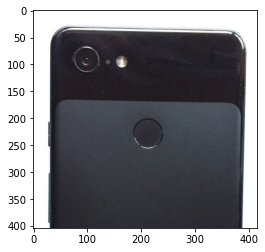

In [15]:
plt.imshow(load_image(df.iloc[0]['image']))

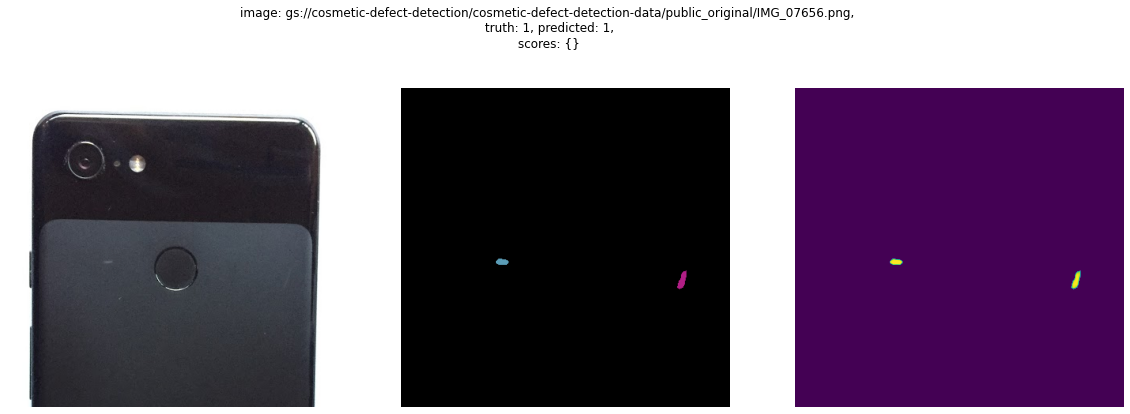

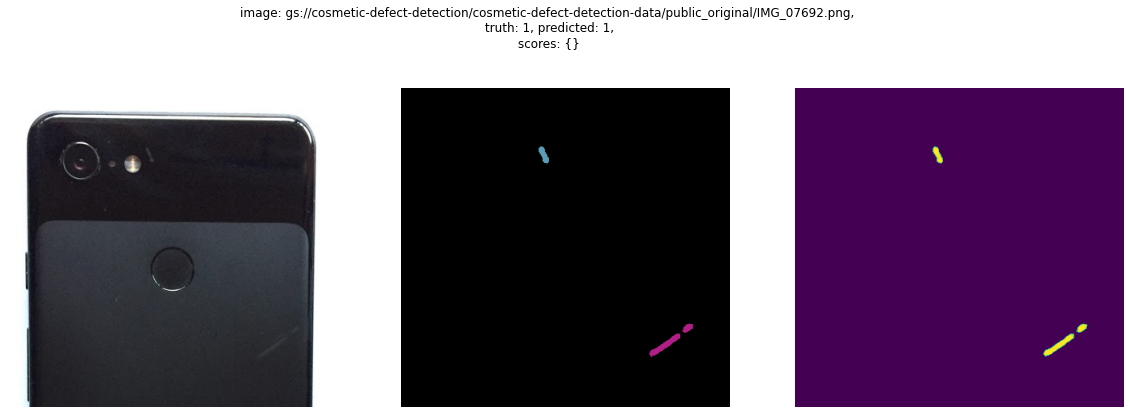

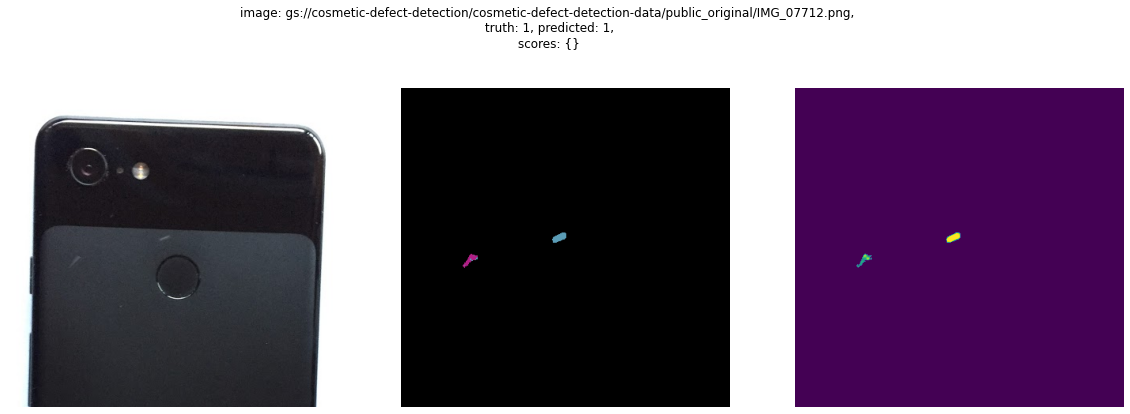

In [16]:
for i in [1, 10, 20]:
    plot_prediction(class_results[i]['image'], mask_results[i]['categories'], mask_results[i]['scores'], '1', '1', {}) 